In [1]:
cd ..

/userdata/jgauthier/projects/ideal-word-representations


In [2]:
from pathlib import Path

import pandas as pd
import seaborn as sns

from transformers import TrainerState

from src.models import get_best_checkpoint

In [12]:
all_model_dirs = Path("outputs/models").glob("*/*/*/*")
checkpoints = []
for d in all_model_dirs:
    if d.stem.startswith("."):
        continue
    try:
        checkpoints.append(Path(get_best_checkpoint(d)))
    except ValueError:
        continue

In [13]:
trainer_states = [TrainerState.load_from_json(c / "trainer_state.json") for c in checkpoints]

In [14]:
log_df = pd.concat([pd.DataFrame(trainer_state.log_history) for trainer_state in trainer_states],
                   keys=["/".join(str(x.stem) for x in c.parents[:4][::-1]) for c in checkpoints], names=["checkpoint"])
log_df

epoch  learning_rate    loss    step  \
checkpoint                                                             
timit/w2v2_6/rnn_8/phoneme 0      0.0       0.001000  5.1346     1.0   
                           1      0.0       0.001000  1.8022    10.0   
                           2      0.0       0.001000 -0.2401    20.0   
                           3      0.0       0.001000 -0.9943    30.0   
                           4      0.0       0.001000 -1.1981    40.0   
...                               ...            ...     ...     ...   
timit/w2v2_6/rnn_3/phoneme 161    0.0       0.000996 -8.7726  1470.0   
                           162    0.0       0.000996 -7.8367  1480.0   
                           163    0.0       0.000996 -8.2808  1490.0   
                           164    0.0       0.000996 -8.1586  1500.0   
                           165    0.0            NaN     NaN  1500.0   

                                eval_embedding_alignment  \
checkpoint                                                 
timit/w2v2_6/rnn_8/phoneme 0                         NaN   
                           1                         NaN   
                           2                         NaN   
                           3                         NaN   
                           4                         NaN   
...                                                  ...   
timit/w2v2_6/rnn_3/phoneme 161                       NaN   
                           162                       NaN   
                           163                       NaN   
                           164                       NaN   
                           165                       NaN   

                                eval_embedding_alignment_cosine  \
checkpoint                                                        
timit/w2v2_6/rnn_8/phoneme 0                                NaN   
                           1                                NaN   
                           2                                NaN   
                           3                                NaN   
                           4                                NaN   
...                                                         ...   
timit/w2v2_6/rnn_3/phoneme 161                              NaN   
                           162                              NaN   
                           163                              NaN   
                           164                              NaN   
                           165                              NaN   

                                eval_embedding_corr  eval_embedding_isoscore  \
checkpoint                                                                     
timit/w2v2_6/rnn_8/phoneme 0                    NaN                      NaN   
                           1                    NaN                      NaN   
                           2                    NaN                      NaN   
                           3                    NaN                      NaN   
                           4                    NaN                      NaN   
...                                             ...                      ...   
timit/w2v2_6/rnn_3/phoneme 161                  NaN                      NaN   
                           162                  NaN                      NaN   
                           163                  NaN                      NaN   
                           164                  NaN                      NaN   
                           165                  NaN                      NaN   

                                eval_embedding_norm  \
checkpoint                                            
timit/w2v2_6/rnn_8/phoneme 0                    NaN   
                           1                    NaN   
                           2                    NaN   
                           3                    NaN   
                           4                    NaN   
...             

In [15]:
log_df_long = log_df.reset_index().melt(id_vars=["checkpoint", "step"], value_vars=["loss", "eval_loss"])
log_df_long

,checkpoint,step,variable,value
0,timit/w2v2_6/rnn_8/phoneme,1.0,loss,5.134600
1,timit/w2v2_6/rnn_8/phoneme,10.0,loss,1.802200
2,timit/w2v2_6/rnn_8/phoneme,20.0,loss,-0.240100
3,timit/w2v2_6/rnn_8/phoneme,30.0,loss,-0.994300
4,timit/w2v2_6/rnn_8/phoneme,40.0,loss,-1.198100
...,...,...,...,...
2825,timit/w2v2_6/rnn_3/phoneme,1470.0,eval_loss,NaN
2826,timit/w2v2_6/rnn_3/phoneme,1480.0,eval_loss,NaN
2827,timit/w2v2_6/rnn_3/phoneme,1490.0,eval_loss,NaN
2828,timit/w2v2_6/rnn_3/phoneme,1500.0,eval_loss,NaN


In [16]:
log_df_long[log_df_long.variable == "eval_loss"].groupby("checkpoint").value.min().sort_values()

checkpoint
timit/w2v2_6/rnn_8/biphone_recon   -9.363153
timit/w2v2_6/rnn_8/word            -9.009235
timit/w2v2_6/rnn_8/syllable        -8.432838
timit/w2v2_6/rnn_8/biphone_pred    -8.346282
timit/w2v2_6/rnn_3/phoneme         -8.344516
timit/w2v2_6/rnn_8/phoneme         -8.131456
timit/w2v2_6/rnn_8/next_phoneme    -6.139058
Name: value, dtype: float64

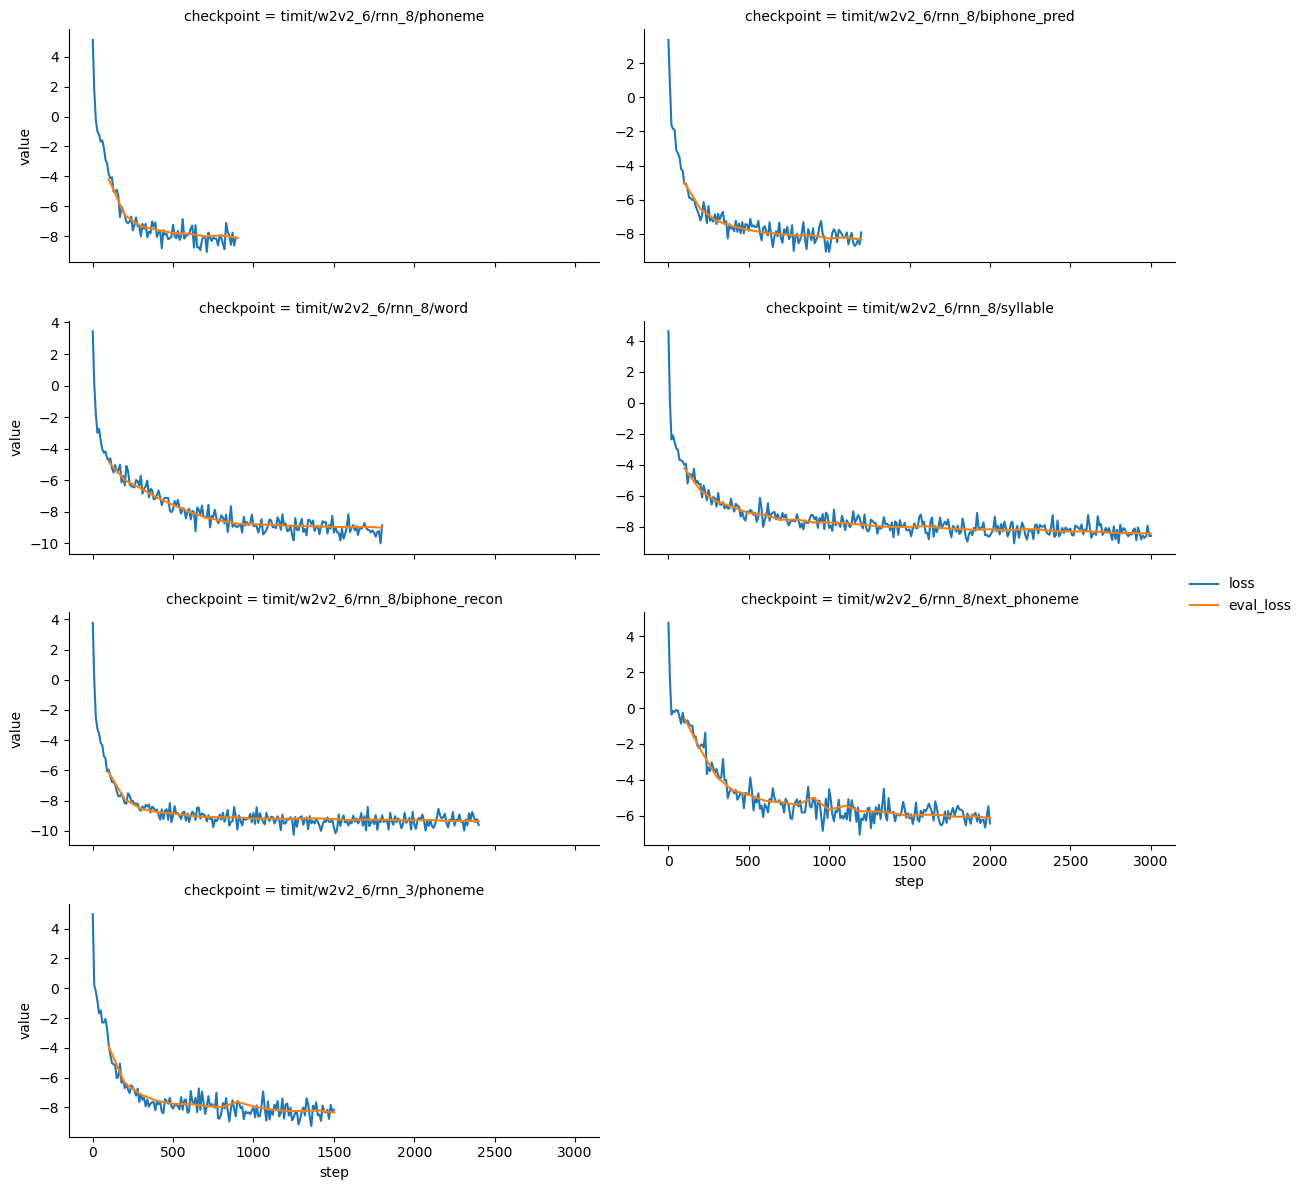

In [17]:
# Plot training and validation loss for all models
g = sns.FacetGrid(log_df_long, col="checkpoint", col_wrap=2, aspect=2, sharey=False)
g.map(sns.lineplot, "step", "value", "variable")
g.add_legend()

## Geometric curves

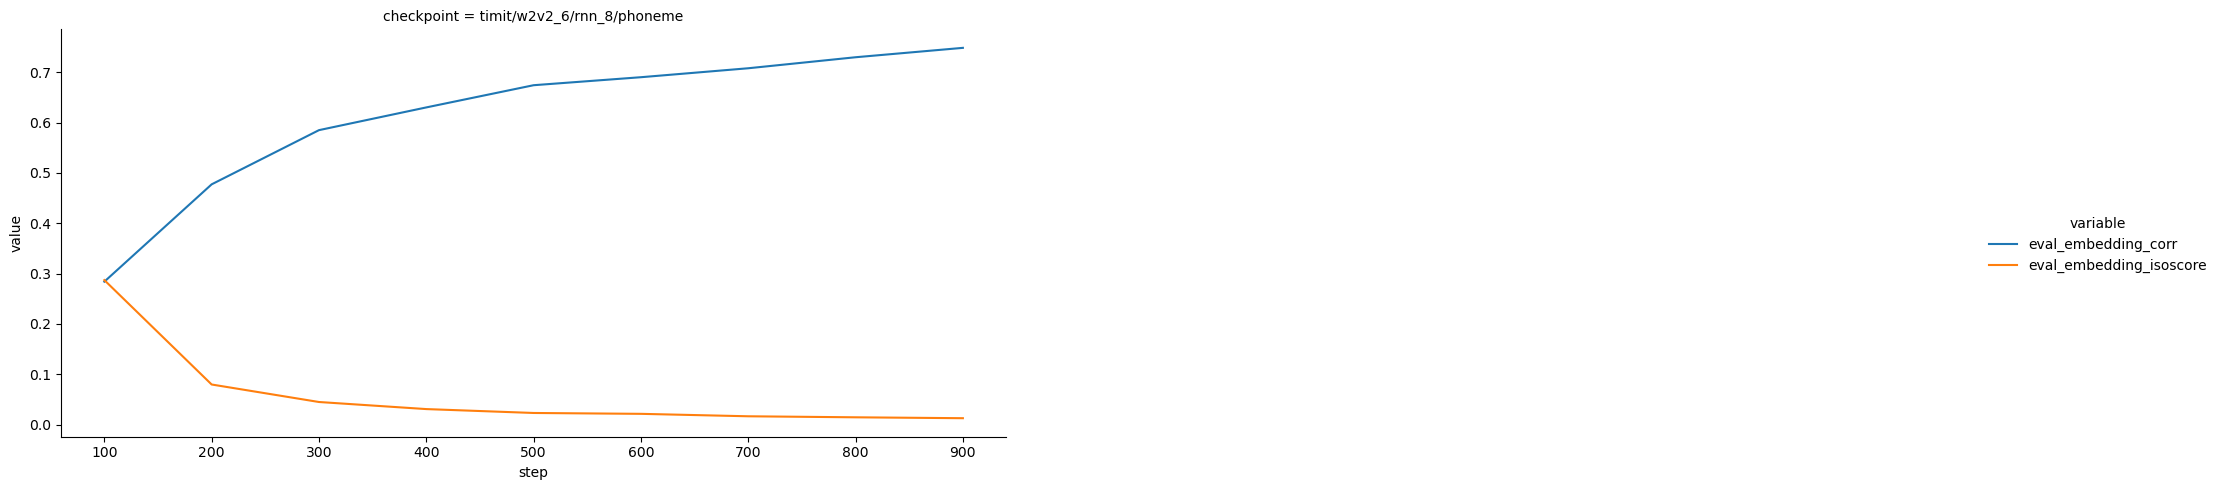

In [27]:
sns.relplot(data=log_df[~log_df.eval_embedding_corr.isna()][["step", "eval_embedding_corr", "eval_embedding_isoscore"]]
                    .reset_index(level=1, drop=True).reset_index().melt(id_vars=["checkpoint", "step"]),
            x="step", y="value", hue="variable", kind="line", col="checkpoint", col_wrap=2, aspect=2)

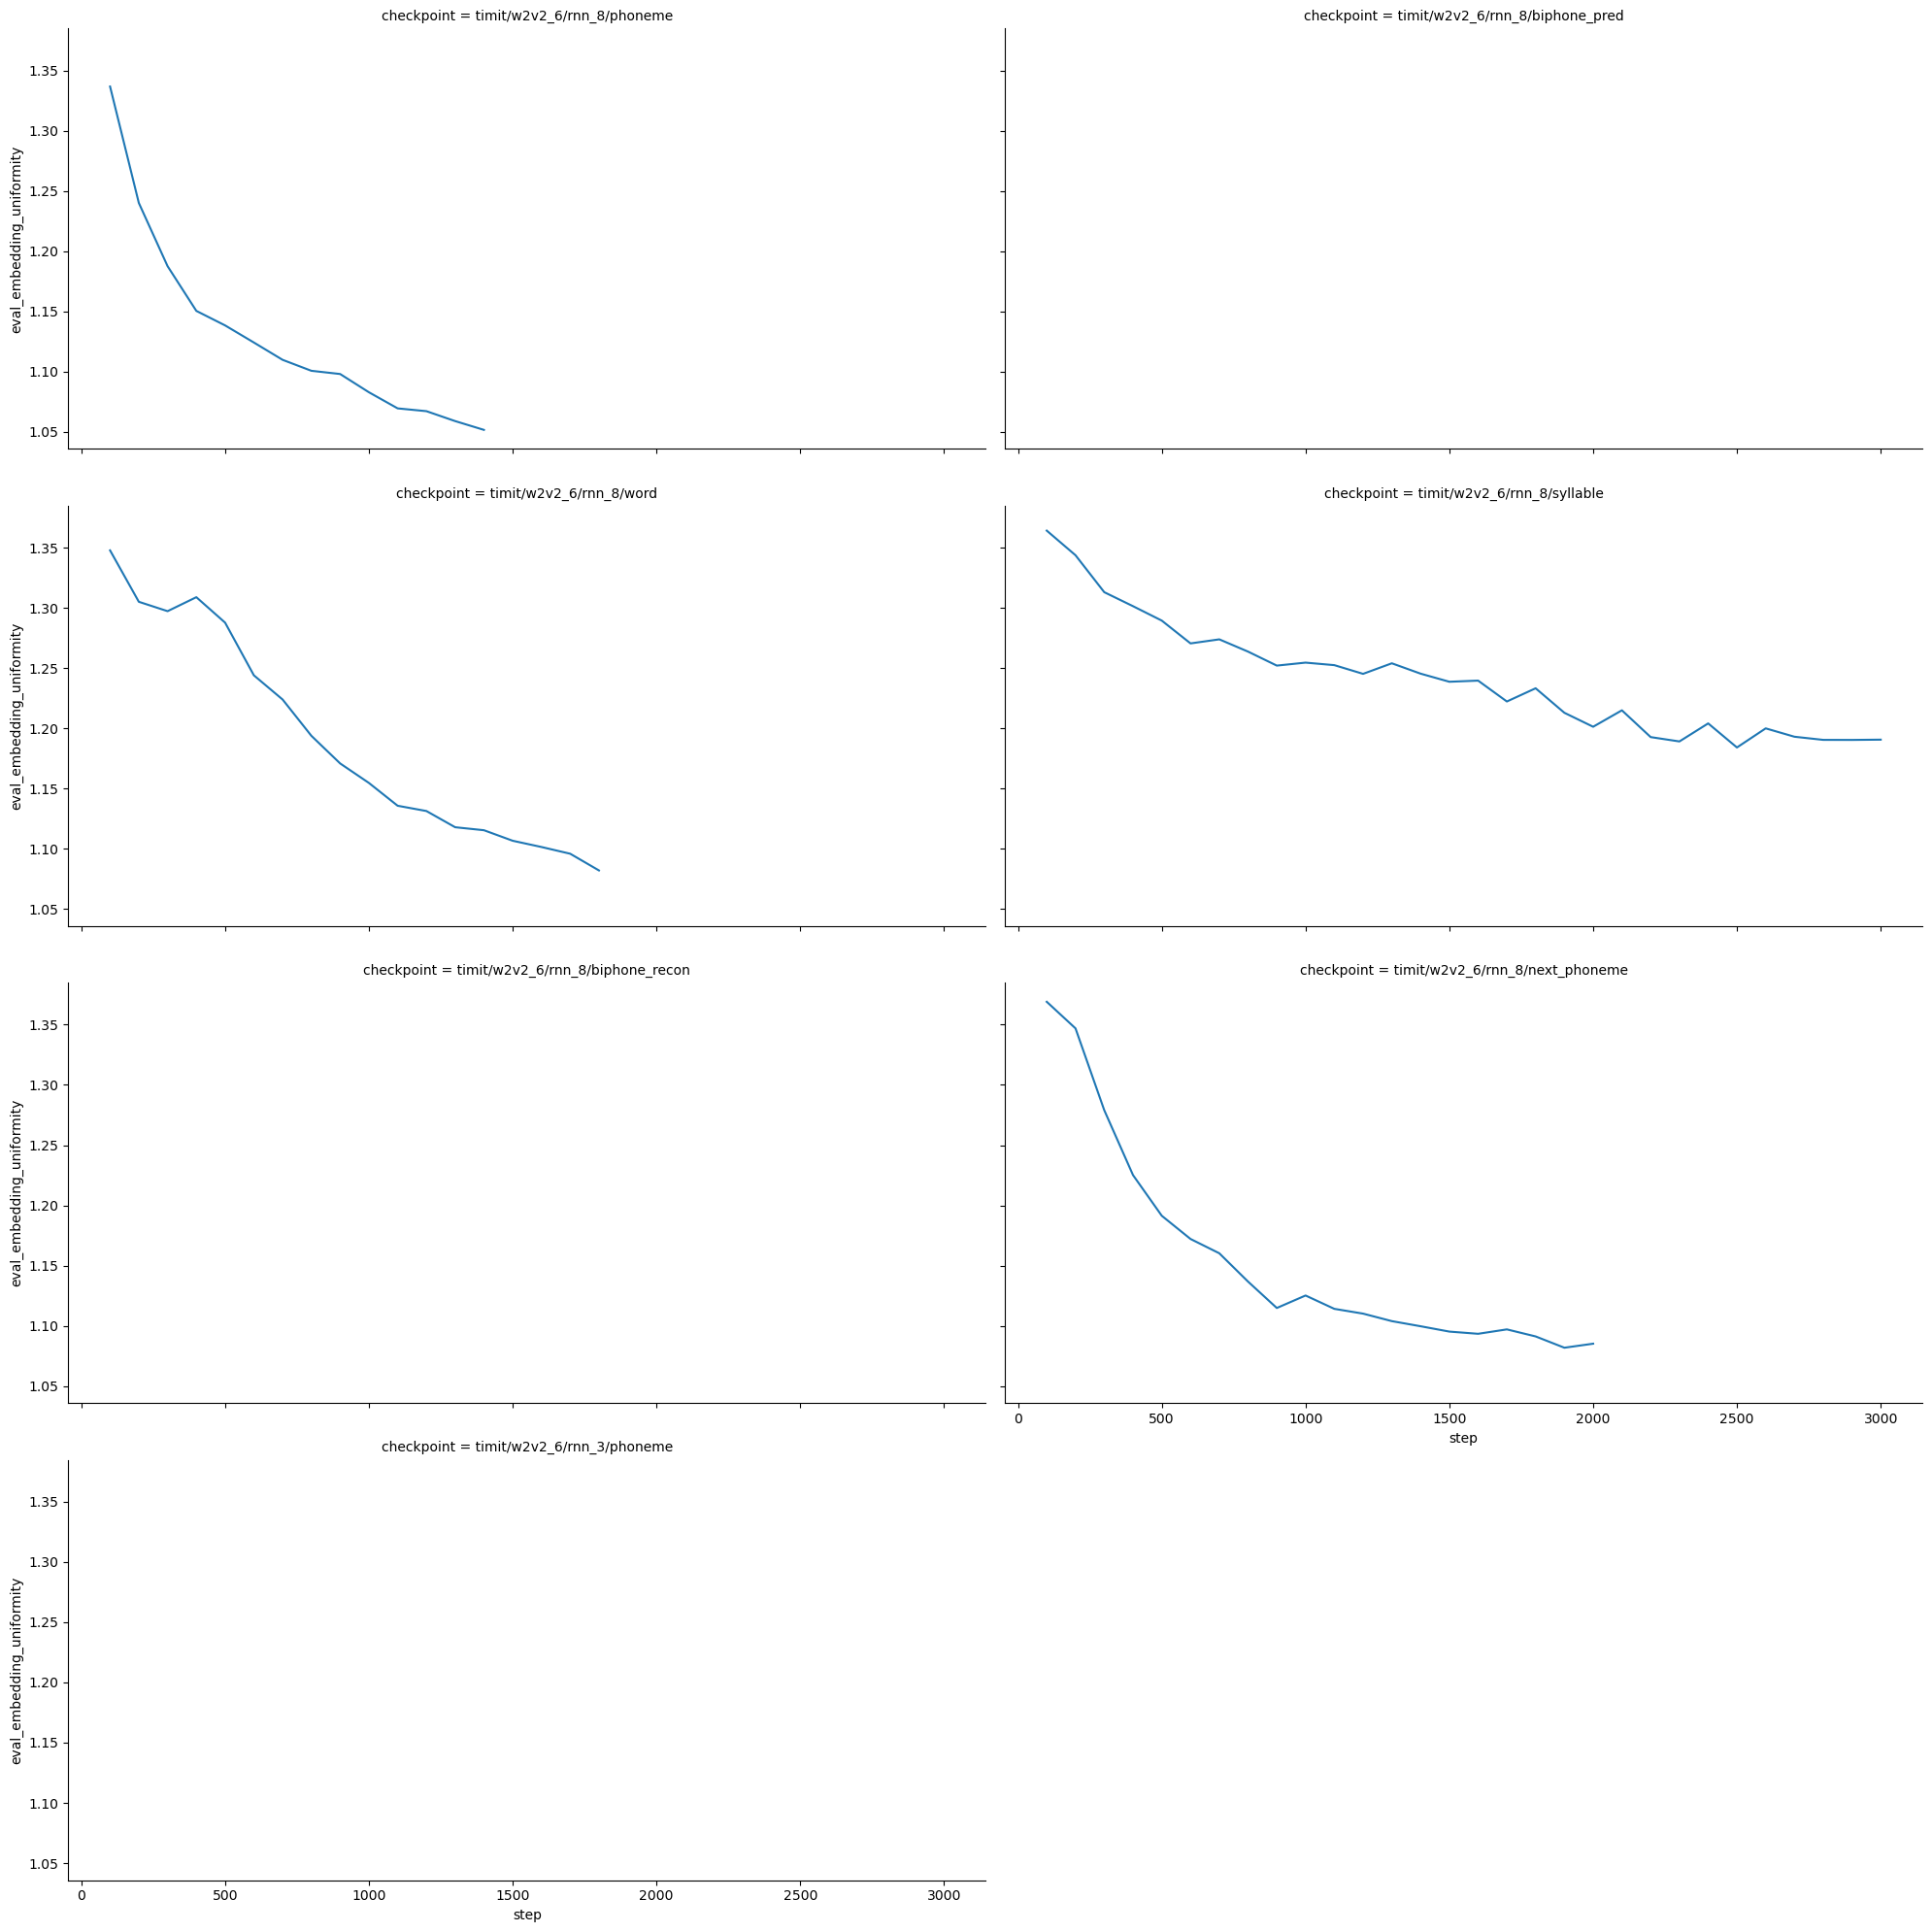

In [ ]:
sns.relplot(data=log_df, x="step", y="eval_embedding_uniformity", kind="line", col="checkpoint", col_wrap=2, aspect=2)